# Que hace esto

LLMs trabajan simultaneamente en el task. Esto se logra corriendo multiples subtasks independientes al mismo tiempo, o coriendo lo mismo multiples veces para ver diferentes outputs

Usado generalmente para
- Splitear subtasks para correrlo paralelo y aumentar la velocidad
- El task corre multiples veces para chequear differet outputs, que aumenta el confidence

# Imports

In [11]:
from typing_extensions import TypedDict
from langchain.chat_models import init_chat_model
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from dotenv import load_dotenv
load_dotenv()

True

# Workflow

## State y LLM

In [5]:
class State(TypedDict):
    topic: str
    joke: str
    story: str
    poem: str
    combined_output: str

In [6]:
llm = init_chat_model(model="gpt-5-nano")

## Nodes

In [7]:
def call_llm_1(state: State):
    msg = llm.invoke(f"Write a joke about {state['topic']}")
    return {"joke": msg.content}

In [8]:
def call_llm_2(state: State):
    msg = llm.invoke(f"Write a story about {state['topic']}")
    return {"story": msg.content}

In [9]:
def call_llm_3(state: State):
    """Third LLM call to generate poem"""

    msg = llm.invoke(f"Write a poem about {state['topic']}")
    return {"poem": msg.content}

In [10]:
def aggregator(state: State):
    """Combine the joke and story into a single output"""

    combined = f"Here's a story, joke, and poem about {state['topic']}!\n\n"
    combined += f"STORY:\n{state['story']}\n\n"
    combined += f"JOKE:\n{state['joke']}\n\n"
    combined += f"POEM:\n{state['poem']}"
    return {"combined_output": combined}

## Builder

In [12]:
parallel_builder = StateGraph(State)

In [13]:
parallel_builder.add_node("call_llm_1", call_llm_1)
parallel_builder.add_node("call_llm_2", call_llm_2)
parallel_builder.add_node("call_llm_3", call_llm_3)
parallel_builder.add_node("aggregator", aggregator)

In [14]:
parallel_builder.add_edge(START, "call_llm_1")
parallel_builder.add_edge(START, "call_llm_2")
parallel_builder.add_edge(START, "call_llm_3")
parallel_builder.add_edge("call_llm_1", "aggregator")
parallel_builder.add_edge("call_llm_2", "aggregator")
parallel_builder.add_edge("call_llm_3", "aggregator")
parallel_builder.add_edge("aggregator", END)
parallel_workflow = parallel_builder.compile()

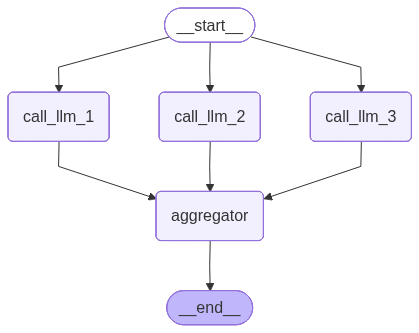

In [15]:
display(Image(parallel_workflow.get_graph().draw_mermaid_png()))

In [16]:
state = parallel_workflow.invoke({"topic": "cats"})
state

{'topic': 'cats',
 'joke': 'Why did the cat sit on the computer? It wanted to keep an eye on the mouse.',
 'story': 'The Moonlit Elm\n\nIn the middle of Willow Park stood an elm that looked older than the town itself, its trunk wide as a small hill and its branches weaving a roof of dark lace above the benches where children once played and grownups once tried to pretend they were still young. In a hollow at the base of that tree lived four cats who ran their own little government by the light of the moon.\n\nThe oldest, and most practical, was Ember. Her fur was the color of autumn leaves just after rain—warm orange with a few stubborn white specks here and there. She wore a calm like a harbor, a steady purring that could soften a quarrel before it began. Then there was Lumen, a silver-gray tabby with eyes that seemed to hold a night sky. Lumen believed every rustle in the grass behind the elm was a story waiting to be read aloud. Willow, a sleek white cat with soft black patches, lov